In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
data = pd.read_csv(r"C:\Users\Mahsa\Desktop\base\energy poverty\Residential total final consumption (TFC) by source - Islamic Republic of Iran.csv",
                   skiprows=3)
data.rename(columns={
    "Unnamed: 0" : "year"
}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                33 non-null     int64  
 1   Oil products        33 non-null     int64  
 2   Natural gas         33 non-null     int64  
 3   Biofuels and waste  33 non-null     int64  
 4   Electricity         33 non-null     int64  
 5   Coal                30 non-null     float64
 6   Units               33 non-null     object 
dtypes: float64(1), int64(5), object(1)
memory usage: 1.9+ KB


In [19]:
data.head()

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
0,1990,350837,109286,3526,62438,NaN,TJ
1,1991,369349,157915,3777,68860,NaN,TJ
2,1992,425104,245763,4402,70232,NaN,TJ
3,1993,407478,269018,4928,79714,774.0,TJ
4,1994,490043,343683,5500,80902,774.0,TJ


In [20]:
data.columns

Index(['year', 'Oil products', 'Natural gas', 'Biofuels and waste',
       'Electricity', 'Coal', 'Units'],
      dtype='object')

In [4]:
data.dropna(inplace = True)

In [5]:
cols = ['Oil products', 'Natural gas', 'Biofuels and waste', 'Electricity', 'Coal']

# Calculate row totals for just these columns
row_totals = data[cols].sum(axis=1)

# Divide each column by the row total
data[cols] = (data[cols].div(row_totals, axis=0))*100

In [23]:
data.head()

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
3,1993,53.480979,35.308277,0.646794,10.462363,0.101587,TJ
4,1994,53.213371,37.320258,0.597241,8.785082,0.084048,TJ
5,1995,50.411096,40.354146,0.539800,8.615708,0.079250,TJ
6,1996,47.381638,43.665891,0.538724,8.339021,0.074726,TJ
7,1997,44.751484,46.106714,0.423696,8.648003,0.070103,TJ


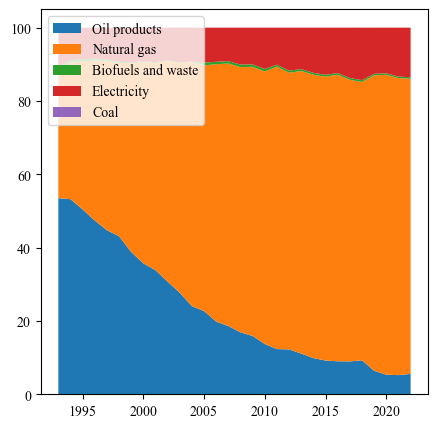

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax.stackplot(data["year"], data[cols].T, labels=cols)

ax.legend(loc='upper left')
plt.show()

In [33]:
data.loc[data["year"]==2022]

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
32,2022,5.552253,80.499857,0.40398,13.530631,0.013278,TJ


# Working on HIES

In [3]:
merged = pd.read_pickle("merged")
merged["Tenure"].unique()

array(['Owner of land and building', 'Free of charge',
       'In exchange for service', 'Rented', 'Other', None, 'Mortgaged',
       'Owner of building only'], dtype=object)

In [3]:
iran_provinces = {
    "آذربایجان شرقی": "East Azerbaijan",
    "آذربایجان غربی": "West Azerbaijan",
    "اردبیل": "Ardabil",
    "اصفهان": "Esfahan",
    "البرز": "Alborz",
    "ایلام": "Ilam",
    "بوشهر": "Bushehr",
    "تهران": "Tehran",
    "خراسان جنوبی": "South Khorasan",
    "خراسان رضوی": "Razavi Khorasan",
    "خراسان شمالی": "North Khorasan",
    "خوزستان": "Khuzestan",
    "زنجان": "Zanjan",
    "سمنان": "Semnan",
    "سیستان و بلوچستان": "Sistan and Baluchestan",
    "فارس": "Fars",
    "قزوین": "Qazvin",
    "قم": "Qom",
    "كردستان": "Kurdistan",
    "كرمان": "Kerman",
    "كهگیلویه و بویراحمد": "Kohgiluyeh and Boyer-Ahmad",
    "لرستان": "Lorestan",
    "مازندران": "Mazandaran",
    "مرکزی": "Markazi",
    "هرمزگان": "Hormozgan",
    "همدان": "Hamadan",
    "چهارمحال و بختیاری": "Chaharmahal and Bakhtiari",
    "کرمانشاه": "Kermanshah",
    "گلستان": "Golestan",
    "گیلان": "Gilan",
    "یزد": "Yazd"
}
data["province"] = data["province"].map(iran_provinces)

In [12]:
def weighted_describe(values, weights):
    values = np.asarray(values)
    weights = np.asarray(weights)

    # Drop NaNs
    mask = ~np.isnan(values)
    values = values[mask]
    weights = weights[mask]

    # Weighted count
    count = weights.sum()

    # Weighted mean
    mean = np.average(values, weights=weights)

    # Weighted variance and std
    variance = np.average((values - mean) ** 2, weights=weights)
    std = np.sqrt(variance)

    # Weighted min and max
    min_val = values.min()
    max_val = values.max()

    # Weighted percentiles
    def weighted_percentile(data, weights, percent):
        """Compute weighted percentile (percent between 0-100)."""
        sorter = np.argsort(data)
        data, weights = data[sorter], weights[sorter]
        cdf = np.cumsum(weights) / weights.sum()
        return np.interp(percent / 100, cdf, data)

    q25 = weighted_percentile(values, weights, 25)
    q50 = weighted_percentile(values, weights, 50)  # median
    q75 = weighted_percentile(values, weights, 75)

    return pd.Series({
        "count": round(count,2),
        "mean": round(mean,2),
        "std": round(std,2),
        "min": round(min_val,2),
        "25%": round(q25,2),
        "50%": round(q50,2),
        "75%": round(q75,2),
        "max": round(max_val,2)
    })


In [4]:
data.isna().sum()

HHID                    0
region                  0
quarter                 0
weight               4356
county_code          1865
                    ...  
OtherEnergyReExp        0
year                    0
all_expenditure         0
all_energy_EXP          0
energy_Ratio        10780
Length: 69, dtype: int64

In [6]:
data = data.loc[data["FoodExp"]!= 0]
data.isna().sum()

HHID                    0
month              150712
household_type          0
region                  0
quarter                 0
                    ...  
OtherExtraSale          0
year                    0
all_expenditure         0
all_energy_EXP          0
energy_Ratio            0
Length: 113, dtype: int64

In [7]:
data["year"] = np.where(
    data["year"] == 1403, 2024, np.where(
        data["year"] == 1402, 2023, np.where(
            data["year"] == 1401, 2022, np.where(
                data["year"] == 1400, 2021, np.where(
                    data["year"] == 99, 2020, np.where(
                        data["year"] == 98, 2019, np.where(
                            data["year"] == 97, 2018, np.where(
                                data["year"] == 96, 2017, np.where(
                                    data["year"] == 95, 2016, np.where(
                                        data["year"] == 94, 2015, np.where(
                                            data["year"] == 93, 2014, np.where(
                                                data["year"] == 92, 2013, np.where(
                                                    data["year"] == 91, 2012, np.where(
                                                        data["year"] == 90, 2011, np.where(
                                                            data["year"] == 89, 2010, pd.NA
                                                        )
                                                    )
                                                )
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_13884\436222094.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=data["year"].unique(), vert=False, flierprops=flierprops)


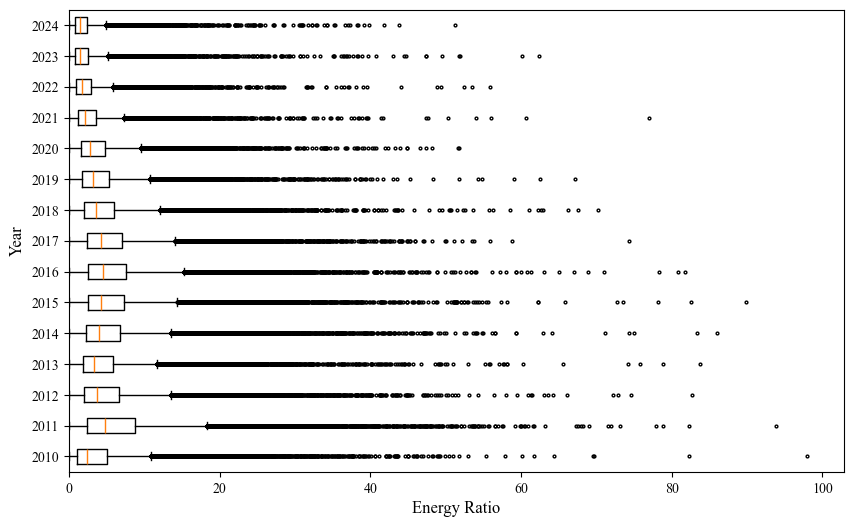

In [ ]:
# Group by year
groups = [data.loc[data["year"] == y, "energy_Ratio"] for y in data["year"].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal boxplot
flierprops = dict(marker='o', markersize=2, linestyle='none')
ax.boxplot(groups, labels=data["year"].unique(), vert=False, flierprops=flierprops)

# Labels with Times New Roman font
ax.set_xlabel("Energy Ratio", fontname="Times New Roman", fontsize=12)
ax.set_ylabel("Year", fontname="Times New Roman", fontsize=12)

# Change tick labels font to Times New Roman
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname("Times New Roman")
plt.xlim(0,40)
plt.show()


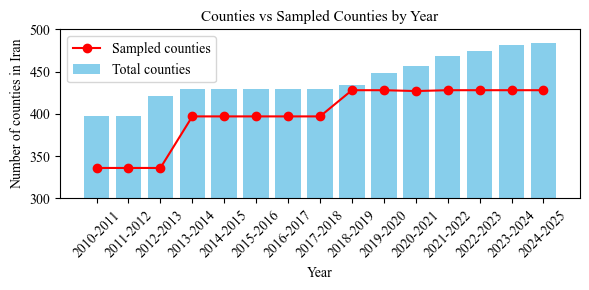

In [11]:
list_ofColumns = [
    "2010-2011",
    "2011-2012",
    "2012-2013",
    "2013-2014",
    "2014-2015",
    "2015-2016",
    "2016-2017",
    "2017-2018",
    "2018-2019",
    "2019-2020",
    "2020-2021",
    "2021-2022",
    "2022-2023",
    "2023-2024",
    "2024-2025"
]
num_counties = [
    397,397,421,429,429,429,429,429,434,448,457,469,474,482,484
]
num_sampled_counties = [
    336,
    336,
    336,
    397,
    397,
    397,
    397,
    397,
    428,
    428,
    427,
    428,
    428,
    428,
    428
]
fig, ax = plt.subplots(figsize=(6, 3))

# Bar chart
ax.bar(list_ofColumns, num_counties, color="skyblue", label="Total counties")

# Line chart on same y-axis
ax.plot(list_ofColumns, num_sampled_counties, color="red", marker='o', label="Sampled counties")

# Labels and limits
ax.set_ylim(300, 500)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of counties in Iran", fontsize=10)
ax.legend(loc="upper left")

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.title("Counties vs Sampled Counties by Year", fontsize=11)
plt.tight_layout()
plt.show()


In [13]:
for col in data.columns:
    print(f"the name of the col is {col}")
    print(data[col].unique())

the name of the col is HHID
['2000025066' '2000077193' '2000149068' ... '12707337550' '12713343553'
 '12105246550']
the name of the col is region
['Rural' 'Urban']
the name of the col is quarter
['spring' 'Summer' 'Fall' 'Winter']
the name of the col is weight
[  153.79051396   153.97073722   140.69929671 ... 13999.
 19426.         12648.        ]
the name of the col is county_code
['0001' '0006' '0010' '0005' '0007' '0011' '0004' '0009' '0003' '0002'
 '0101' '0105' '0103' '0104' '0111' '0107' '0106' '0112' '0114' '0102'
 '0116' '0108' '0109' '0115' '0110' '0113' '0221' '0214' '0207' '0201'
 '0218' '0219' '0202' '0205' '0220' '0210' '0215' '0216' '0204' '0208'
 '0206' '0222' '0307' '0313' '0316' '0311' '0325' '0305' '0302' '0310'
 '0320' '0312' '0303' '0324' '0314' '0322' '0306' '0315' '0323' '0321'
 '0319' '0402' '0412' '0413' '0401' '0407' '0411' '0406' '0403' '0410'
 '0414' '0408' '0405' '0404' '0409' '0504' '0505' '0514' '0502' '0512'
 '0501' '0511' '0508' '0509' '0503' '0510' '051

In [8]:
cols = [
    'Electricity',
    'Pipegas',
    'Phone',
    'Internet',
    'Bathroom',
    'Kitchen',
    'Cooler_water',
    'Centralcooler',
    'Centralheat',
    'Pakage',
    'Cooler_gas',
    'Sewer_network'
]
for col in cols:
    data[col] = np.where(data[col]==0,0,1)
    print(data[col].unique())

[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [9]:
cols = [
'Cookfuel',
'Heatfuel',
'Hotwaterfuel',
]
for col in cols:
    df = data.groupby(col).size()
    print(df)

Cookfuel
Animal fuel                  10
Diesel                      147
Electricity                 149
Firewood and charcoal       602
LPG                      131859
Natural gas              436304
None                         58
Other fuels                   3
White oil                  1197
dtype: int64
Heatfuel
Animal fuel                 125
Diesel                      536
Electricity               23496
Firewood and charcoal      2889
LPG                        5825
Natural gas              434383
None                      10671
Other fuels                  33
White oil                 92371
dtype: int64
Hotwaterfuel
Animal fuel                 188
Diesel                      832
Electricity               47447
Firewood and charcoal      3961
LPG                       48823
Natural gas              433557
None                       5330
Other fuels                 157
White oil                 30034
dtype: int64


In [10]:
cols = [
'PrivateVehicle',
'Motorcycle',
'Bike',
'Radio',
'Cassette',
'TVbw',
'TV',
'VideoPlayer',
'Computer',
'Cellphone',
'Freezer',
'Refrigerator',
'Freez_refrig',
'Vacuum',
'Washer',
'Sewing',
'Fan',
'Cooler_water_portable',
'Cooler_gas_portable',
'Dishwasher',
'None',
'Pipewater',
'Electricity',
'Pipegas',
'Phone',
'Internet',
'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
'Sewer_network',
'HeadWoman'
]
for col in cols:
    data[col] = data[col].astype(bool)

In [11]:
data["Tenure"] = np.where(data["Tenure"].isin(['Owner of land and building', 'Free of charge',
                                               'In exchange for service','Owner of building only']), "Owner",np.where(
                                                  data["Tenure"].isin(['Rented', 'Mortgaged']), "Renter", 'Other'))

In [13]:
province_to_climate = {
    "Tehran": "BSh",
    "Khuzestan": "BSh",
    "Bushehr": "BSh",
    "Yazd": "BWk",
    "Alborz": "Dsa",
    "Kurdistan": "Dsa",
    "Hamadan": "Dsa",
    "Ardabil": "BSk",
    "East Azerbaijan": "BSk",
    "Zanjan": "BSk",
    "Golestan": "BSk",
    "North Khorasan": "BSk",
    "Razavi Khorasan": "BSk",
    "Gilan": "Cfa",
    "Qom": "BWh",
    "Semnan": "BWh",
    "Esfahan": "BWh",
    "South Khorasan": "BWh",
    "Kerman": "BWh",
    "Hormozgan": "BWh",
    "Sistan and Baluchestan": "BWh",
}

data["climate"] = data["province"].map(province_to_climate).fillna("Csa")

In [15]:
data["GeClimate"] = np.where(data["climate"].isin(['Csa', 'Cfa']), "C", np.where(
    data["climate"].isin(['BSk', 'BSh', 'BWh', 'BWk']), "B", "D"
))
data.groupby(["climate", "GeClimate"]).size()

climate  GeClimate
BSh      B             65334
BSk      B            118135
BWh      B            130767
BWk      B             18898
Cfa      C             18399
Csa      C            173220
Dsa      D             45576
dtype: int64

In [4]:
#data.to_pickle("data.pkl")
data = pd.read_pickle("data.pkl")


In [14]:
for year in data["year"].unique():
    df = data.loc[(data["year"]==year)]
    hh_all = df["weight"].sum()
    df2 = data.loc[(data["year"]==year)& (data["Electricity"]==True)]
    hh_access = df2["weight"].sum()
    por = (hh_access/hh_all) * 100
    print(f"in {year} the proportion of households have access through the electricity network is {round(por,1)}")

in 2010 the proportion of households have access through the electricity network is 99.9
in 2011 the proportion of households have access through the electricity network is 99.9
in 2012 the proportion of households have access through the electricity network is 99.9
in 2013 the proportion of households have access through the electricity network is 99.9
in 2014 the proportion of households have access through the electricity network is 100.0
in 2015 the proportion of households have access through the electricity network is 100.0
in 2016 the proportion of households have access through the electricity network is 100.0
in 2017 the proportion of households have access through the electricity network is 100.0
in 2018 the proportion of households have access through the electricity network is 100.0
in 2019 the proportion of households have access through the electricity network is 100.0
in 2020 the proportion of households have access through the electricity network is 100.0
in 2021 the pr

In [23]:
for year in data["year"].unique():
    df = data.loc[(data["year"]==year)]
    hh_all = df["weight"].sum()
    df2 = data.loc[(data["year"]==year)& (data["Pipegas"]==True)]
    hh_access = df2["weight"].sum()
    por = (hh_access/hh_all) * 100
    print(f"in {year} the proportion of households have access through the pipe gas is {round(por,1)}")

in 2010 the proportion of households have access through the pipe gas is 78.2
in 2011 the proportion of households have access through the pipe gas is 79.1
in 2012 the proportion of households have access through the pipe gas is 81.1
in 2013 the proportion of households have access through the pipe gas is 81.4
in 2014 the proportion of households have access through the pipe gas is 83.0
in 2015 the proportion of households have access through the pipe gas is 84.3
in 2016 the proportion of households have access through the pipe gas is 85.7
in 2017 the proportion of households have access through the pipe gas is 87.0
in 2018 the proportion of households have access through the pipe gas is 88.1
in 2019 the proportion of households have access through the pipe gas is 89.3
in 2020 the proportion of households have access through the pipe gas is 90.7
in 2021 the proportion of households have access through the pipe gas is 91.6
in 2022 the proportion of households have access through the pip

In [25]:
for year in data["year"].unique():
    df = data.loc[data["year"]==year]
    print(weighted_describe(df["Area"], df["weight"]))

count    20033978.28
mean           92.83
std            47.94
min             3.00
25%            60.00
50%            85.00
75%           120.00
max           700.00
dtype: float64
count    21088589.38
mean           93.53
std            46.46
min             6.00
25%            60.00
50%            85.00
75%           120.00
max           990.00
dtype: float64
count    21714928.02
mean           95.24
std            46.49
min             5.00
25%            65.00
50%            90.00
75%           120.00
max           800.00
dtype: float64
count    22594080.41
mean           93.33
std            41.67
min             6.00
25%            67.00
50%            90.00
75%           115.00
max           710.00
dtype: float64
count    23327856.93
mean           93.69
std            40.82
min             6.00
25%            70.00
50%            90.00
75%           115.00
max           600.00
dtype: float64
count    24053802.41
mean           94.09
std            40.40
min             6.00
2

In [8]:
for year in data["year"].unique():
    df = data.loc[data["year"]==year]
    print(weighted_describe(df["HHsize"], df["weight"]))

count    20033978.28
mean            3.81
std             1.67
min             1.00
25%             3.00
50%             4.00
75%             5.00
max            19.00
dtype: float64
count    21088589.38
mean            3.77
std             1.63
min             1.00
25%             3.00
50%             4.00
75%             5.00
max            18.00
dtype: float64
count    21714928.02
mean            3.70
std             1.59
min             1.00
25%             3.00
50%             4.00
75%             5.00
max            20.00
dtype: float64
count    22594080.41
mean            3.56
std             1.48
min             1.00
25%             3.00
50%             3.00
75%             4.00
max            19.00
dtype: float64
count    23327856.93
mean            3.54
std             1.46
min             1.00
25%             3.00
50%             3.00
75%             4.00
max            16.00
dtype: float64
count    24053802.41
mean            3.52
std             1.44
min             1.00
2

In [15]:
for year in data["year"].unique():
    df = data.loc[(data["year"]==year)&(data["region"]=="Urban")]
    hh_all = df["weight"].sum()
    df2 = df.loc[(df["Tenure"]=="Renter")]
    hh_renter = df2["weight"].sum()
    por = (hh_renter/hh_all) * 100
    print(f"in {year} the proportion of renter is {round(por,1)}")

in 2010 the proportion of renter is 23.6
in 2011 the proportion of renter is 23.0
in 2012 the proportion of renter is 21.7
in 2013 the proportion of renter is 26.0
in 2014 the proportion of renter is 24.3
in 2015 the proportion of renter is 24.3
in 2016 the proportion of renter is 25.2
in 2017 the proportion of renter is 25.0
in 2018 the proportion of renter is 26.4
in 2019 the proportion of renter is 24.2
in 2020 the proportion of renter is 23.0
in 2021 the proportion of renter is 23.2
in 2022 the proportion of renter is 23.7
in 2023 the proportion of renter is 23.2
in 2024 the proportion of renter is 23.2


In [16]:
df = data.loc[(data["Tenure"]=="Renter")&(data["year"]==2024)&(data["region"]=="Urban")]
df["HouseExpRatio"] = 100*((df["RentExp"]+df["EstRentExp"])/df["all_expenditure"])
weighted_describe(df["HouseExpRatio"], weights= df["weight"])

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_8972\387557293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["HouseExpRatio"] = 100*((df["RentExp"]+df["EstRentExp"])/df["all_expenditure"])


count   5098086.00
mean         32.00
std          10.65
min           0.64
25%          25.15
50%          31.20
75%          38.10
max          83.00
dtype: float64

In [16]:
for year in data["year"].unique():
    df = data.loc[data["year"]==year]
    pop_all = (df["weight"] * df["HHsize"]).sum()
    df2 = df.loc[df["region"]=="Urban"]
    pop_urb = (df2["weight"] * df2["HHsize"]).sum()
    urb = (pop_urb/pop_all) * 100
    print(f"in {year} with the population of {round(pop_all,0)} the urbanization rate is {round(urb,1)}")

in 2010 with the population of 76381960.0 the urbanization rate is 71.4
in 2011 with the population of 79409564.0 the urbanization rate is 70.9
in 2012 with the population of 80256928.0 the urbanization rate is 72.6
in 2013 with the population of 80498319.0 the urbanization rate is 71.9
in 2014 with the population of 82464916.0 the urbanization rate is 72.2
in 2015 with the population of 84649741.0 the urbanization rate is 72.8
in 2016 with the population of 86488780.0 the urbanization rate is 73.0
in 2017 with the population of 86308522.0 the urbanization rate is 74.6
in 2018 with the population of 85636983.0 the urbanization rate is 74.8
in 2019 with the population of 86799571.0 the urbanization rate is 75.2
in 2020 with the population of 87742734.0 the urbanization rate is 75.6
in 2021 with the population of 88245682.0 the urbanization rate is 75.9
in 2022 with the population of 88868658.0 the urbanization rate is 76.5
in 2023 with the population of 88842403.0 the urbanization rate 

# Random Forest

In [7]:
data = data[['HHID',
'region',
'quarter',
'weight',
'county_code',
'province_code',
'HHsize',
"AveAge",
'NumChild_U5',
'NumChild_B5_7',
'NumChild_B7_18',
'NumChildOver18',
'HeadWoman',
'Num_Literate',
'NumEmployed',
'NumOld',
'NumMale',
'Tenure',
'Room',
'Area',
'Skeleton',
'MainMaterial',
'PrivateVehicle',
'Motorcycle',
'Bike',
'Radio',
'Cassette',
'TVbw',
'TV',
'VideoPlayer',
'Computer',
'Cellphone',
'Freezer',
'Refrigerator',
'Freez_refrig',
'Vacuum',
'Washer',
'Sewing',
'Fan',
'Cooler_water_portable',
'Cooler_gas_portable',
'Dishwasher',
'None',
'Pipewater',
'Electricity',
'Pipegas',
'Phone',
'Internet',
'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
'Sewer_network',
'Cookfuel',
'Heatfuel',
'Hotwaterfuel',
'FoodExp',
'ElectricityExp',
'ElectricityOtherExp',
'NaturalGasExp',
'NaturalGasOtherExp',
'OtherEnergyReExp',
'year',
'all_expenditure',
'all_energy_EXP',
'energy_Ratio',
"GeClimate"]]

In [54]:
df1 = pd.get_dummies(data = data['Tenure'], prefix='Tenure_')
df2 = pd.get_dummies(data = data['region'], prefix='region_')
df3 = pd.get_dummies(data = data['quarter'], prefix='quarter_')
df4 = pd.get_dummies(data = data['Skeleton'], prefix='Skeleton_')
df5 = pd.get_dummies(data = data['Cookfuel'], prefix='Cookfuel_')
df6 = pd.get_dummies(data = data['Heatfuel'], prefix='Heatfuel_')
df7 = pd.get_dummies(data = data['Hotwaterfuel'], prefix='Hotwaterfuel_')
df8 = pd.get_dummies(data = data['GeClimate'], prefix='Climate_')
joindb = data.join(df1).join(df2).join(df3).join(df4).join(df5).join(df6).join(df7).join(df8)
joindb.drop(columns = [
    'Tenure','region','quarter','Skeleton','Cookfuel','Heatfuel','Hotwaterfuel',
    'region__Rural',
    "MainMaterial",
    "quarter__Fall","quarter__Summer","quarter__spring",
    "Skeleton__Other","Skeleton__Metal",
    'Cookfuel__Animal fuel', 'Cookfuel__Diesel', 'Cookfuel__Electricity','Cookfuel__Firewood and charcoal', 'Cookfuel__LPG', 'Cookfuel__None', 'Cookfuel__Other fuels','Cookfuel__White oil',
    'Heatfuel__Animal fuel', 'Heatfuel__Diesel', 'Heatfuel__Electricity','Heatfuel__Firewood and charcoal', 'Heatfuel__LPG', 'Heatfuel__None', 'Heatfuel__Other fuels','Heatfuel__White oil',
    'Hotwaterfuel__Animal fuel', 'Hotwaterfuel__Diesel','Hotwaterfuel__Electricity', 'Hotwaterfuel__Firewood and charcoal','Hotwaterfuel__LPG', 'Hotwaterfuel__None','Hotwaterfuel__Other fuels', 'Hotwaterfuel__White oil',
    'Tenure__Other', 'Tenure__Owner',    
    'FoodExp', 'ElectricityExp', 'ElectricityOtherExp', 'NaturalGasExp','NaturalGasOtherExp', 'OtherEnergyReExp', 'all_energy_EXP',
    'Motorcycle', 'PrivateVehicle',
    'Bike',
    'Radio',
    'Cassette',
    'TVbw',
    'TV',
    'VideoPlayer',
    'Computer',
    'Cellphone',
    'Freezer',
    'Refrigerator',
    'Freez_refrig',
    'Vacuum',
    'Washer',
    'Sewing',
    'Fan',
    'Cooler_water_portable',
    'None',
    'Phone','Internet',
    'GeClimate'
    ], inplace = True)

In [55]:
for col in joindb.columns:
    print("\n", col)
    print(joindb[col].unique())


 HHID
['2000025066' '2000077193' '2000149068' ... '12707337550' '12713343553'
 '12105246550']

 weight
[  153.79051396   153.97073722   140.69929671 ... 13999.
 19426.         12648.        ]

 county_code
['0001' '0006' '0010' '0005' '0007' '0011' '0004' '0009' '0003' '0002'
 '0101' '0105' '0103' '0104' '0111' '0107' '0106' '0112' '0114' '0102'
 '0116' '0108' '0109' '0115' '0110' '0113' '0221' '0214' '0207' '0201'
 '0218' '0219' '0202' '0205' '0220' '0210' '0215' '0216' '0204' '0208'
 '0206' '0222' '0307' '0313' '0316' '0311' '0325' '0305' '0302' '0310'
 '0320' '0312' '0303' '0324' '0314' '0322' '0306' '0315' '0323' '0321'
 '0319' '0402' '0412' '0413' '0401' '0407' '0411' '0406' '0403' '0410'
 '0414' '0408' '0405' '0404' '0409' '0504' '0505' '0514' '0502' '0512'
 '0501' '0511' '0508' '0509' '0503' '0510' '0513' '0507' '0506' '0601'
 '0611' '0605' '0615' '0603' '0606' '0616' '0608' '0604' '0614' '0618'
 '0610' '0619' '0620' '0607' '0612' '0613' '0609' '0602' '0617' '0712'
 '0710' '070

In [ ]:
#joindb.to_pickle("joindb.pkl")
joindb = pd.read_pickle("joindb.pkl")

In [57]:
joindb.columns.to_list()

['HHID',
 'weight',
 'county_code',
 'province_code',
 'HHsize',
 'AveAge',
 'NumChild_U5',
 'NumChild_B5_7',
 'NumChild_B7_18',
 'NumChildOver18',
 'HeadWoman',
 'Num_Literate',
 'NumEmployed',
 'NumOld',
 'NumMale',
 'Room',
 'Area',
 'Cooler_gas_portable',
 'Dishwasher',
 'Pipewater',
 'Electricity',
 'Pipegas',
 'Bathroom',
 'Kitchen',
 'Cooler_water',
 'Centralcooler',
 'Centralheat',
 'Pakage',
 'Cooler_gas',
 'Sewer_network',
 'year',
 'all_expenditure',
 'energy_Ratio',
 'Tenure__Renter',
 'region__Urban',
 'quarter__Winter',
 'Skeleton__concrete',
 'Cookfuel__Natural gas',
 'Heatfuel__Natural gas',
 'Hotwaterfuel__Natural gas',
 'Climate__B',
 'Climate__C',
 'Climate__D']

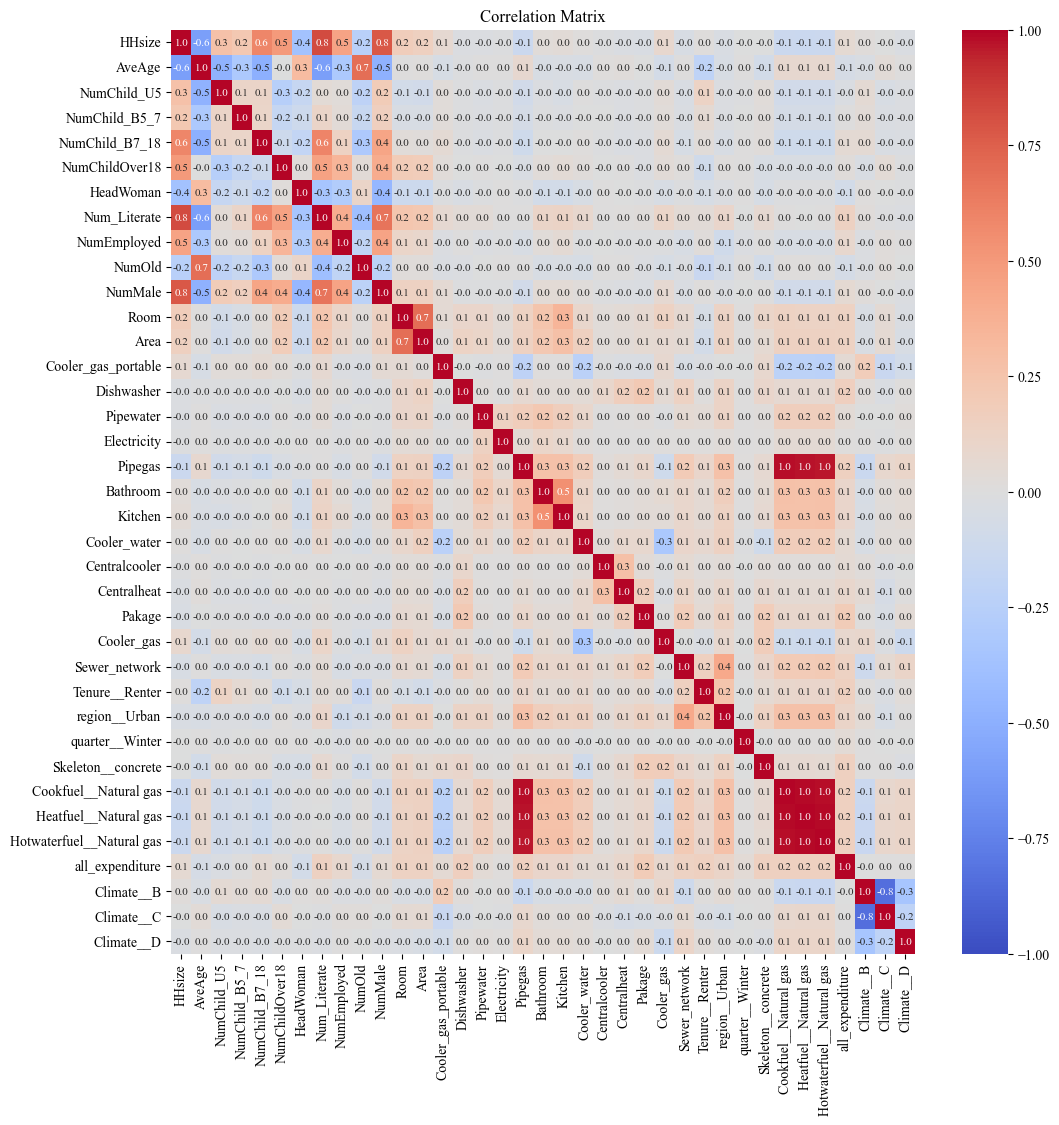

In [ ]:
x_vars = [
'HHsize',
'AveAge',
'NumChild_U5',
'NumChild_B5_7',
'NumChild_B7_18',
'NumChildOver18',
'HeadWoman',
'Num_Literate',
'NumEmployed',
'NumOld',
'NumMale',
'Room',
'Area',
'Cooler_gas_portable',
'Dishwasher',
'Pipewater',
'Electricity',
'Pipegas',
'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
'Sewer_network',
'Tenure__Renter',
'region__Urban',
'quarter__Winter',
'Skeleton__concrete',
'Cookfuel__Natural gas',
'Heatfuel__Natural gas',
'Hotwaterfuel__Natural gas',
'all_expenditure',
'Climate__B',
'Climate__C',
'Climate__D'
]
corr_matrix = joindb[x_vars].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

In [70]:
x_vars = [
'HHsize',
#'AveAge',
'NumChild_U5',
'NumChild_B5_7',
#'NumChild_B7_18',
#'NumChildOver18',
'HeadWoman',
#'Num_Literate',
#'NumEmployed',
'NumOld',
#'NumMale',
#'Room',
'Area',
'Cooler_gas_portable',
'Dishwasher',
'Pipewater',
'Electricity',
'Pipegas',
#'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
#'Sewer_network',
'Tenure__Renter',
'region__Urban',
'quarter__Winter',
'Skeleton__concrete',
#'Cookfuel__Natural gas',
#'Heatfuel__Natural gas',
#'Hotwaterfuel__Natural gas',
'Climate__B',
#'Climate__C',
#'Climate__D'
]
y_var = 'energy_Ratio'
w_var = 'weight'
df2 = pd.DataFrame()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
for year in joindb["year"].unique():
    df = joindb.loc[joindb["year"]==year]
    X_train, X_test, y_train, y_test ,w_train, w_test = train_test_split(
        df[x_vars], df[y_var], df[w_var],test_size = 0.25, random_state = 1)
    print(f"\n The year {year}")
    print(len(X_train), len(y_train) )
    print(len(X_test), len(y_test) )
    rfr = RandomForestRegressor(n_estimators = 400, random_state = 1, n_jobs=-1, max_depth=5)
    rfr.fit(X_train,y_train, sample_weight=w_train)
    y_pred = rfr.predict(X_test)
    
    
    # --- Evaluation Metrics ---
    mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
    mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred, sample_weight=w_test)
    
    # Print results
    print(f"MAE:  {mae:.3f}")
    print(f"MSE:  {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")
    
    impo = pd.Series(rfr.feature_importances_, index=X_train.columns, name=year)
    # Collect into df2
    df2 = pd.concat([df2, impo], axis=1)
    
    


 The year 2010
28627 28627
9543 9543
MAE:  2.517
MSE:  15.901
RMSE: 3.988
R²:   0.115

 The year 2011
28825 28825
9609 9609
MAE:  4.053
MSE:  36.553
RMSE: 6.046
R²:   0.087

 The year 2012
28586 28586
9529 9529
MAE:  3.041
MSE:  24.130
RMSE: 4.912
R²:   0.108

 The year 2013
28680 28680
9561 9561
MAE:  2.467
MSE:  14.547
RMSE: 3.814
R²:   0.146

 The year 2014
28641 28641
9548 9548
MAE:  2.830
MSE:  18.710
RMSE: 4.325
R²:   0.118

 The year 2015
28607 28607
9536 9536
MAE:  2.865
MSE:  19.925
RMSE: 4.464
R²:   0.144

 The year 2016
28516 28516
9506 9506
MAE:  2.989
MSE:  20.943
RMSE: 4.576
R²:   0.149

 The year 2017
28395 28395
9465 9465
MAE:  2.713
MSE:  16.470
RMSE: 4.058
R²:   0.153

 The year 2018
29144 29144
9715 9715
MAE:  2.286
MSE:  12.383
RMSE: 3.519
R²:   0.159

 The year 2019
28647 28647
9549 9549
MAE:  2.169
MSE:  11.815
RMSE: 3.437
R²:   0.146

 The year 2020
28041 28041
9348 9348
MAE:  1.899
MSE:  8.864
RMSE: 2.977
R²:   0.157

 The year 2021
28369 28369
9457 9457
MAE:  

In [ ]:
#df2.to_pickle("df2.pkl")
df2 = pd.read_pickle("df2.pkl")

In [72]:
df2= pd.read_pickle("df2.pkl")
df2= df2.reset_index(drop=False)
df2["mean"] = df2.select_dtypes(include="number").mean(axis=1)
df2= df2.sort_values("mean", ascending=False)

In [73]:
df2

,index,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,mean
17,Tenure__Renter,0.215214,0.338626,0.319567,0.326633,0.357655,0.360701,0.351178,0.372843,0.339314,0.396769,0.378350,0.307606,0.326015,0.285611,0.370518,0.336440
0,HHsize,0.095418,0.186176,0.145525,0.146549,0.198694,0.232615,0.258508,0.254855,0.242854,0.250938,0.240113,0.284097,0.208054,0.278430,0.217950,0.216052
10,Pipegas,0.133185,0.029577,0.159242,0.077449,0.011497,0.012496,0.014835,0.020456,0.011802,0.037691,0.166707,0.132937,0.157762,0.125840,0.169442,0.084061
18,region__Urban,0.091562,0.073420,0.028525,0.072908,0.132083,0.097041,0.078575,0.170296,0.109376,0.114582,0.031830,0.031762,0.027152,0.002985,0.010079,0.071478
12,Cooler_water,0.029220,0.056995,0.029110,0.025063,0.056997,0.113692,0.089843,0.059534,0.095801,0.018165,0.053755,0.066112,0.077445,0.090081,0.024383,0.059080
5,Area,0.073284,0.076263,0.059114,0.046319,0.045003,0.024010,0.051904,0.047995,0.071447,0.027286,0.022736,0.061883,0.046584,0.088812,0.059751,0.053493
4,NumOld,0.104582,0.105288,0.081757,0.101533,0.074698,0.037198,0.026380,0.020850,0.067999,0.043249,0.006323,0.012101,0.017108,0.012404,0.002644,0.047608
19,quarter__Winter,0.135900,0.036263,0.065964,0.141486,0.071726,0.070062,0.087558,0.003379,0.000807,0.015361,0.002266,0.006221,0.004844,0.006246,0.003543,0.043442
21,Climate__B,0.003112,0.010294,0.027917,0.013805,0.003267,0.001751,0.001210,0.000910,0.002467,0.002671,0.005571,0.016317,0.018779,0.054206,0.041266,0.013570
3,HeadWoman,0.019663,0.010338,0.020097,0.013250,0.006235,0.029585,0.013644,0.013000,0.005703,0.016070,0.012685,0.003596,0.004907,0.001612,0.012625,0.012201


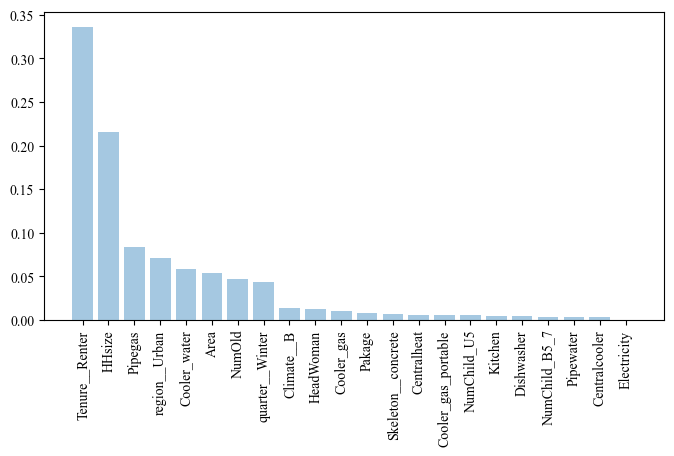

In [82]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(df2["index"],df2["mean"], alpha = 0.4)
plt.xticks(rotation = 90)
plt.show()
    

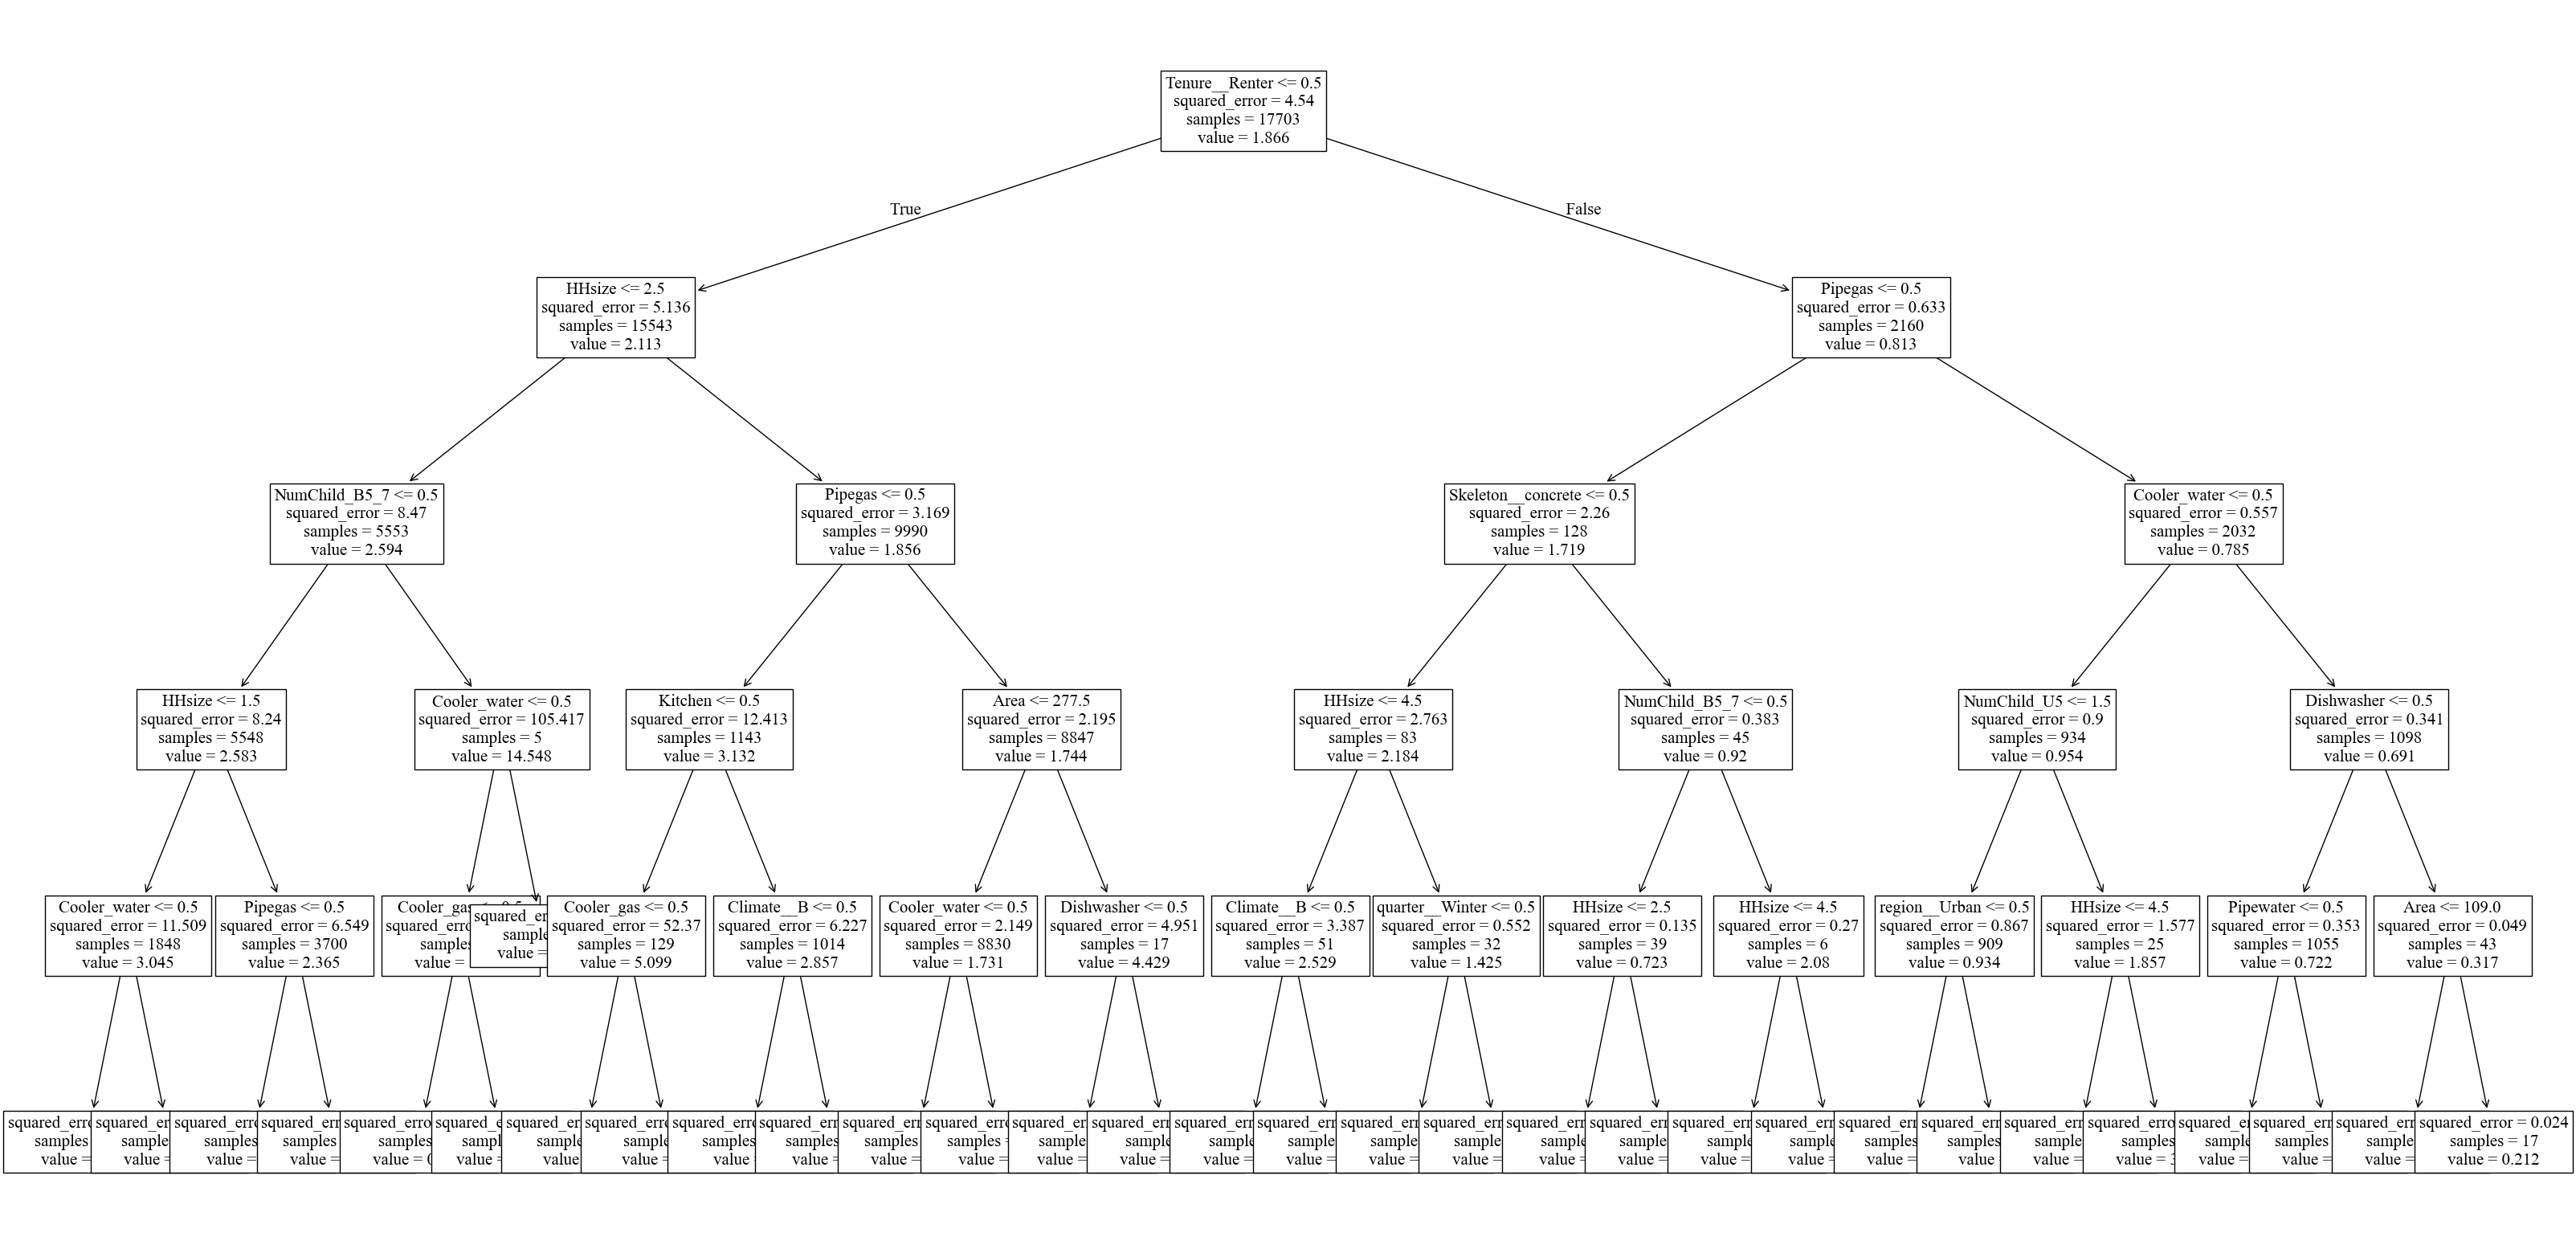

In [69]:
# now we have 100 estimators (trees), so let's pick the first one to visualize
e = rfr.estimators_[0]

from sklearn import tree
fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

# Data exploration

In [22]:
#data.to_pickle("data.pkl")
data = pd.read_pickle("data.pkl")
data["num_child"] = data["NumChild_U5"]+ data["NumChild_B5_7"]+ data["NumChild_B7_18"]+ data["NumChildOver18"]

In [17]:
for year in range(2010, 2025):
    df = data.loc[data["year"]==year]
    num = df["county_code"].nunique()
    print(f"in year {year} the number of sampled counties is {num}")

in year 2010 the number of sampled counties is 336
in year 2011 the number of sampled counties is 336
in year 2012 the number of sampled counties is 336
in year 2013 the number of sampled counties is 397
in year 2014 the number of sampled counties is 397
in year 2015 the number of sampled counties is 397
in year 2016 the number of sampled counties is 397
in year 2017 the number of sampled counties is 397
in year 2018 the number of sampled counties is 428
in year 2019 the number of sampled counties is 428
in year 2020 the number of sampled counties is 427
in year 2021 the number of sampled counties is 428
in year 2022 the number of sampled counties is 428
in year 2023 the number of sampled counties is 428
in year 2024 the number of sampled counties is 428


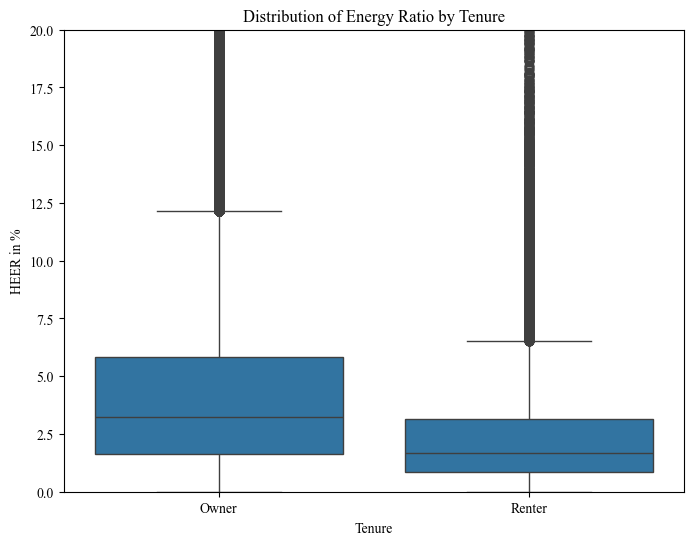

In [18]:
df = data.loc[data["Tenure"]!= "Other"]
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    y="energy_Ratio",
    x="Tenure"        # or "count" if you want raw counts
)

plt.title("Distribution of Energy Ratio by Tenure")
plt.ylabel("HEER in %")
plt.xlabel("Tenure")
plt.ylim(0,20)
plt.show()

In [19]:
dic = {
    "year":[],
    "HHsize": [],
    "energy_ratio": []
}
for year in data["year"].unique():
    df = data.loc[data["year"]==year]
    for s in df["HHsize"].unique():
        df2 = df.loc[df["HHsize"]==s]
        mean = np.average(df2["energy_Ratio"], weights=df2["weight"])
        dic["year"].append(year)
        dic["HHsize"].append(s)
        dic["energy_ratio"].append(mean)     
df_f = pd.DataFrame(dic)
df_f.head()

,year,HHsize,energy_ratio
0,2010,7.00,3.47
1,2010,6.00,3.36
2,2010,3.00,3.22
3,2010,5.00,3.28
4,2010,2.00,3.77


In [20]:
df_pivot = pd.pivot(data = df_f, index ="HHsize", columns = "year", values= "energy_ratio").reset_index(drop = False)
df_pivot.columns.name = ""
print(df_pivot)
print(df_pivot.isna().sum())


    HHsize  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  \
0     1.00  5.09  8.86  6.81  6.44  7.35  7.97  8.26  7.83  6.78  6.00  5.17   
1     2.00  3.77  7.36  5.55  4.75  5.59  5.94  6.36  5.70  4.96  4.39  3.97   
2     3.00  3.22  6.01  4.58  3.87  4.44  4.82  4.84  4.53  3.93  3.52  3.10   
3     4.00  3.01  5.75  4.24  3.70  4.37  4.42  4.52  4.20  3.62  3.23  2.86   
4     5.00  3.28  5.58  4.23  3.78  4.54  4.58  4.89  4.56  3.94  3.52  3.11   
5     6.00  3.36  5.63  4.42  3.96  4.60  4.82  5.21  4.86  4.21  3.51  3.38   
6     7.00  3.47  5.83  4.51  3.92  4.81  4.86  5.32  4.78  4.43  3.58  3.12   
7     8.00  3.36  5.71  4.30  3.86  4.76  5.06  5.55  4.57  4.06  3.48  3.00   
8     9.00  3.41  5.81  4.34  4.59  4.31  5.31  5.86  6.66  3.31  3.19  3.10   
9    10.00  3.30  6.45  4.81  3.96  4.53  5.11  4.55  5.15  3.57  3.40  2.88   
10   11.00  3.63  5.24  4.07  7.84  4.10  4.43  5.18  4.51  4.56  4.65  1.98   
11   12.00  4.05  3.69  3.90  4.52  3.21

In [23]:
df_long = data.melt(
    id_vars="HHsize",
    value_vars=["num_child", "NumNotfirstR"],
    var_name="Variable",
    value_name="Value"
)
df_long

,HHsize,Variable,Value
0,7.00,num_child,5.00
1,6.00,num_child,4.00
2,3.00,num_child,1.00
3,5.00,num_child,3.00
4,2.00,num_child,0.00
...,...,...,...
1140653,3.00,NumNotfirstR,0.00
1140654,2.00,NumNotfirstR,0.00
1140655,4.00,NumNotfirstR,1.00
1140656,3.00,NumNotfirstR,0.00


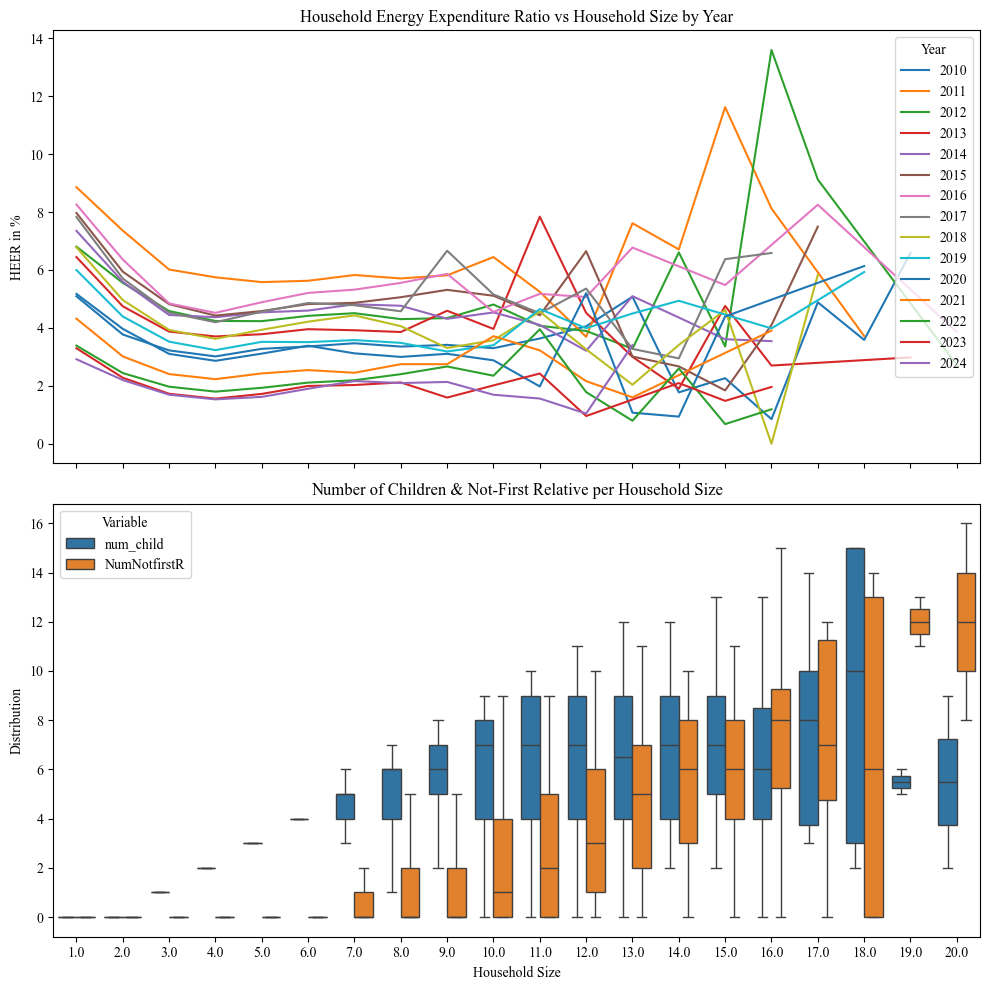

In [24]:
# --- Create two vertically stacked subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- 1️⃣ Line plot: Energy Ratio vs Household Size ---
for year in range(2010, 2025):
    sns.lineplot(
        x = df_pivot["HHsize"]-1, 
        y = df_pivot[year], 
        label=str(year),
        ax = ax1
    )

ax1.set_xlabel("")  # Hide x-label (shared with second plot)
ax1.set_ylabel("HEER in %")
ax1.legend(title="Year")
ax1.set_title("Household Energy Expenditure Ratio vs Household Size by Year")

# --- 2️⃣ Boxplot: Children & Not-First Residents per Household Size ---
sns.boxplot(
    data=df_long,
    x="HHsize",
    y="Value",
    hue="Variable",
    showfliers=False,
    ax=ax2
)

ax2.set_xlabel("Household Size")
ax2.set_ylabel("Distribution")
ax2.set_title("Number of Children & Not-First Relative per Household Size")

plt.tight_layout()
plt.show()

<Axes: xlabel='HHsize', ylabel='number'>

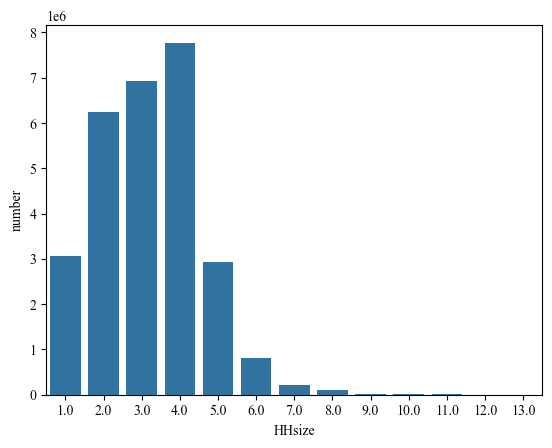

In [ ]:
# how many households we have in each household size group
df = data.groupby(['HHsize','year']).agg(
    year = ("year", "first"),
    HHsize = ("HHsize", "first"),
    number = ("weight", "sum")
).reset_index(drop = True)
df["number"] = df["number"].astype(int)
df = df[df["year"]==2024]
sns.barplot(
    x = df["HHsize"],
    y = df["number"]
)

In [43]:
all = df["number"].sum(axis=0)
lower_part = df[df["HHsize"]>6]["number"].sum(axis = 0)
print(f"the proportion of certain families is {round(lower_part/all,3)}")

the proportion of certain families is 0.013


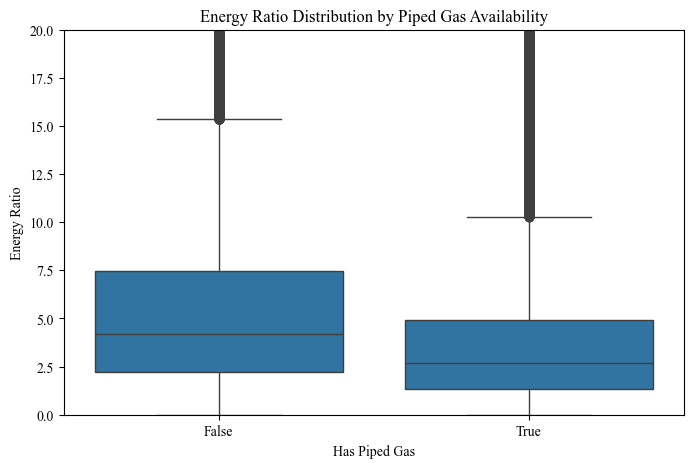

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=data,
    x="Pipegas",
    y="energy_Ratio"
)
plt.xlabel("Has Piped Gas")
plt.ylabel("Energy Ratio")
plt.ylim(0,20)
plt.title("Energy Ratio Distribution by Piped Gas Availability")
plt.show()


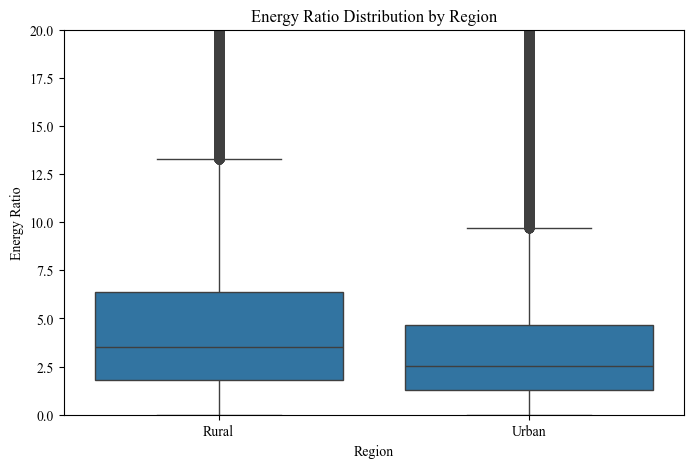

In [65]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=data,
    x="region",
    y="energy_Ratio"
)
plt.xlabel("Region")
plt.ylabel("Energy Ratio")
plt.ylim(0,20)
plt.title("Energy Ratio Distribution by Region")
plt.show()

In [11]:
cols = [
'Cookfuel',
'Heatfuel',
'Hotwaterfuel',
]
for col in cols:
    df = data.groupby([col, "Pipegas"]).size()
    print(df)

Cookfuel               Pipegas
Animal fuel            False          10
Diesel                 False         138
                       True            9
Electricity            False          58
                       True           91
Firewood and charcoal  False         595
                       True            7
LPG                    False      129361
                       True         2498
Natural gas            False        1454
                       True       434850
None                   False          56
                       True            2
Other fuels            False           2
                       True            1
White oil              False        1143
                       True           54
dtype: int64
Heatfuel               Pipegas
Animal fuel            False         124
                       True            1
Diesel                 False         502
                       True           34
Electricity            False       22719
                       

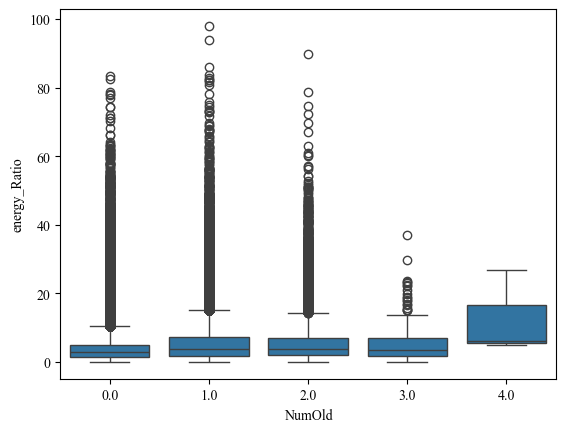

In [14]:
sns.boxplot(
    data = data,
    x = "NumOld",
    y = "energy_Ratio"
)
plt.show()

# Energy poverty calculation

In [3]:
data = pd.read_pickle("data.pkl")

In [44]:
def weighted_mean(x):
    return np.average(x["energy_Ratio"], weights=x["weight"])

df = (
    data
    .groupby(["Tenure", "HHsize", "region", "quarter","NumOld","year"])
    .apply(weighted_mean)
    .reset_index(name="weighted_energy_ratio")
)

In [45]:
df

,Tenure,HHsize,region,quarter,NumOld,year,weighted_energy_ratio
0,Other,1.00,Rural,Fall,0.00,2012,8.53
1,Other,1.00,Rural,Fall,0.00,2013,11.53
2,Other,1.00,Rural,Fall,0.00,2014,4.19
3,Other,1.00,Rural,Fall,0.00,2016,16.11
4,Other,1.00,Rural,Fall,0.00,2018,6.22
...,...,...,...,...,...,...,...
6547,Renter,16.00,Rural,Fall,0.00,2011,1.10
6548,Renter,16.00,Urban,Winter,0.00,2013,3.11
6549,Renter,16.00,Urban,spring,0.00,2012,0.00
6550,Renter,17.00,Rural,Fall,0.00,2012,15.89


In [46]:
df[["weighted_energy_ratio"]].isna().sum()

weighted_energy_ratio    0
dtype: int64

In [47]:
df["2m"] = df["weighted_energy_ratio"]*2

In [48]:
data2 = pd.merge(data, df, on = ["Tenure", "HHsize", "region", "quarter","NumOld", "year"], how = "left")
data2.shape[0] == data.shape[0]

True

In [49]:
data2["is_energyPoor"] = np.where(data2["energy_Ratio"]> data2["2m"], 1,0)

In [50]:
data2[["HHID","county_code","province_code","province","weight","is_energyPoor"]].head()

,HHID,county_code,province_code,province,weight,is_energyPoor
0,2000025066,0001,00,Markazi,153.79,0
1,2000077193,0006,00,Markazi,153.97,0
2,2000149068,0001,00,Markazi,140.70,0
3,2000125050,0010,00,Markazi,90.18,1
4,2000065114,0005,00,Markazi,196.92,0


In [51]:
df = data2.groupby(["is_energyPoor","year"]).agg(
    num_HH = ("weight", "sum")
).reset_index(drop = False)
df = pd.pivot(data = df, index = "year", columns= "is_energyPoor", values= "num_HH")
df.reset_index(drop= False, inplace= True)

In [53]:
df.rename(columns= {
    0:"Not EnergyPoor",
    1:"EnergyPoor"
}, inplace = True)
df["pop_hh"] = df["Not EnergyPoor"]+ df["EnergyPoor"]
df["energy_ratio"] = 100*(df["EnergyPoor"]/df["pop_hh"])
print(df[["year","energy_ratio"]])

is_energyPoor  year  energy_ratio
0              2010         11.82
1              2011         11.15
2              2012         10.37
3              2013          9.67
4              2014          9.18
5              2015          8.96
6              2016          9.14
7              2017          9.23
8              2018          9.16
9              2019          9.13
10             2020          9.07
11             2021          9.02
12             2022          8.42
13             2023          9.21
14             2024          9.04


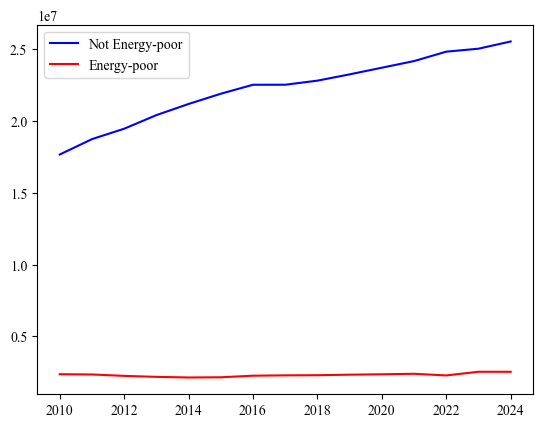

In [54]:
plt.plot(df["year"],df["Not EnergyPoor"], color = "blue", label = "Not Energy-poor")
plt.plot(df["year"], df["EnergyPoor"], color = "red", label = "Energy-poor")
plt.legend()
plt.show()

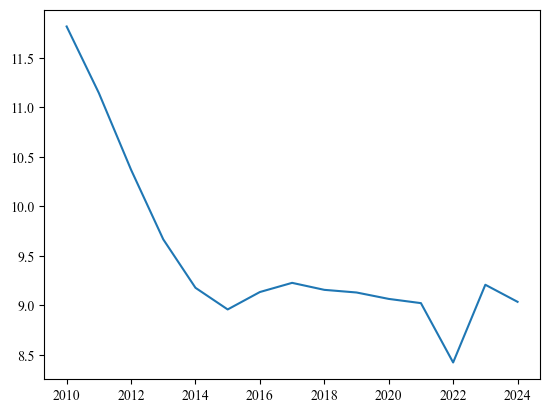

In [32]:
plt.plot(df["year"], df["energy_ratio"])
plt.show()

In [57]:
data2["energyPoor_HH"] = data2["weight"]*data2["is_energyPoor"]
province_df = data2.groupby(["year","province_code"]).agg(
    energyPoor_HH = ("energyPoor_HH", "sum"),
    HH = ("weight", "sum")
).reset_index(drop = False)
county_df = data2.groupby(["year","county_code"]).agg(
    energyPoor_HH = ("energyPoor_HH", "sum"),
    HH = ("weight", "sum")
).reset_index(drop = False)

province_df["energyPoorPer"] =100* (province_df["energyPoor_HH"]/province_df["HH"])
county_df["energyPoorPer"] =100* (county_df["energyPoor_HH"]/county_df["HH"])

print(province_df.head())
print(county_df.head())

   year province_code  energyPoor_HH         HH  energyPoorPer
0  2010            00       75583.94  418280.88          18.07
1  2010            01      114659.58  756945.78          15.15
2  2010            02      166477.47  883461.08          18.84
3  2010            03      111366.61 1041171.14          10.70
4  2010            04       90768.52  749082.53          12.12
   year county_code  energyPoor_HH        HH  energyPoorPer
0  2010        0001       30483.46 192256.15          15.86
1  2010        0002        2014.44   6415.33          31.40
2  2010        0003        4069.91  15964.97          25.49
3  2010        0004        5749.64  34168.61          16.83
4  2010        0005        2041.38  14539.28          14.04


In [59]:
for year in range(2010,2025):
    a = round(province_df.loc[province_df["year"]==year]["HH"].sum(),0)
    b = round(county_df.loc[county_df["year"]==year]["HH"].sum(),0)
    print(f"In {year}, the number of households is {a} and the sum of it in both datasets equal {a==b}")

In 2010, the number of households is 20033978.0 and the sum of it in both datasets equal True
In 2011, the number of households is 21088589.0 and the sum of it in both datasets equal True
In 2012, the number of households is 21714928.0 and the sum of it in both datasets equal True
In 2013, the number of households is 22594080.0 and the sum of it in both datasets equal True
In 2014, the number of households is 23327857.0 and the sum of it in both datasets equal True
In 2015, the number of households is 24053802.0 and the sum of it in both datasets equal True
In 2016, the number of households is 24789207.0 and the sum of it in both datasets equal True
In 2017, the number of households is 24815850.0 and the sum of it in both datasets equal True
In 2018, the number of households is 25109049.0 and the sum of it in both datasets equal True
In 2019, the number of households is 25584111.0 and the sum of it in both datasets equal True
In 2020, the number of households is 26074941.0 and the sum 

In [60]:
data2.head()

,HHID,month,household_type,region,quarter,weight,county_code,province_code,province,HHsize,...,all_expenditure,all_energy_EXP,energy_Ratio,climate,GeClimate,num_child,weighted_energy_ratio,2m,is_energyPoor,energyPoor_HH
0,2000025066,1,NormalResiding,Rural,spring,153.79,0001,00,Markazi,7.00,...,2085551.67,142000.00,6.81,Csa,C,5.00,5.10,10.20,0,0.00
1,2000077193,2,NormalResiding,Rural,spring,153.97,0006,00,Markazi,6.00,...,7162222.33,320000.00,4.47,Csa,C,4.00,4.35,8.70,0,0.00
2,2000149068,2,NormalResiding,Rural,spring,140.70,0001,00,Markazi,3.00,...,3056012.67,40000.00,1.31,Csa,C,1.00,4.64,9.27,0,0.00
3,2000125050,2,NormalResiding,Rural,spring,90.18,0010,00,Markazi,5.00,...,2071836.67,220000.00,10.62,Csa,C,3.00,4.30,8.60,1,90.18
4,2000065114,2,NormalResiding,Rural,spring,196.92,0005,00,Markazi,2.00,...,1383481.33,85000.00,6.14,Csa,C,0.00,6.45,12.89,0,0.00


In [76]:
df = data2
df1 = pd.pivot_table(
    data=df,
    index="year",
    columns="region",
    values="energyPoor_HH",
    aggfunc="sum"
)
df2 = df.groupby(["year", "region"]).agg(
    year = ("year", "first"),
    region = ("region", "first"),
    total_HH = ("weight", "sum")
).reset_index(drop = True)
df2 = df2.pivot(index="year", columns= "region", values= "total_HH")
df2.rename(columns = {
    "Rural": "total_rural",
    "Urban": "total_urban"
}, inplace= True)
df3 = pd.merge(df1,df2, on = "year", how= "inner").reset_index(drop = False)
df3["urban_per"] = round((df3["Urban"]/df3["total_urban"])*100, 2)
df3["rural_per"] = round((df3["Rural"]/df3["total_rural"])*100, 2)
df3[["year", "urban_per", "rural_per"]]

region,year,urban_per,rural_per
0,2010,11.65,12.27
1,2011,11.10,11.28
2,2012,10.16,10.98
3,2013,9.62,9.79
4,2014,8.86,10.08
5,2015,8.85,9.28
6,2016,9.16,9.08
7,2017,9.16,9.43
8,2018,9.14,9.20
9,2019,9.04,9.41


# GIS ready process

In [73]:
print(province_df.shape)
print(province_df.shape[0]==31*15)
province_df.head()

(465, 5)
True


,year,province_code,energyPoor_pop,pop,energyPoorPer
0,2010,00,75583.94,418280.88,18.07
1,2010,01,114659.58,756945.78,15.15
2,2010,02,166477.47,883461.08,18.84
3,2010,03,111366.61,1041171.14,10.70
4,2010,04,90768.52,749082.53,12.12


In [76]:
print(county_df.shape, 429*15)
print(county_df.shape[0]==429*15)
county_df.head()

(5988, 5) 6435
False


,year,county_code,energyPoor_pop,pop,energyPoorPer
0,2010,0001,30483.46,192256.15,15.86
1,2010,0002,2014.44,6415.33,31.40
2,2010,0003,4069.91,15964.97,25.49
3,2010,0004,5749.64,34168.61,16.83
4,2010,0005,2041.38,14539.28,14.04


In [84]:
province_df2 = pd.pivot(data = province_df, index = "province_code", columns= "year", values = "energyPoorPer")
province_df2= province_df2.reset_index(drop= False)

In [77]:
county_df2 = pd.pivot(data = county_df, index = "county_code", columns= "year", values = "energyPoorPer")
county_df2 = county_df2.reset_index(drop = False)

<Axes: >

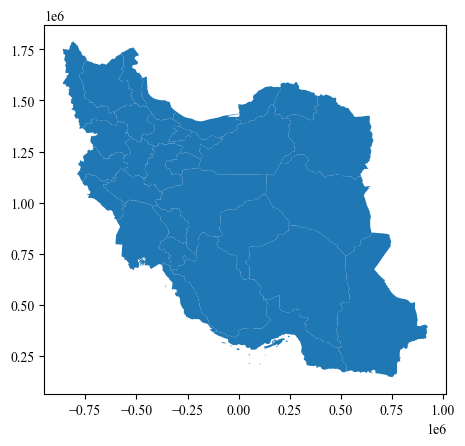

In [107]:
iran_provinces = gpd.read_file(r"C:\Users\Mahsa\Desktop\base\PHD3\bargh\naghshe_organization.gdb", layer="province_main")
iran_provinces.plot()

In [108]:
province_names = {
    "آذربایجان شرقی": "East Azerbaijan",
    "آذربایجان غربی": "West Azerbaijan",
    "اردبیل": "Ardabil",
    "اصفهان": "Esfahan",
    "البرز": "Alborz",
    "ایلام": "Ilam",
    "بوشهر": "Bushehr",
    "تهران": "Tehran",
    "خراسان جنوبی": "South Khorasan",
    "خراسان رضوی": "Razavi Khorasan",
    "خراسان شمالی": "North Khorasan",
    "خوزستان": "Khuzestan",
    "زنجان": "Zanjan",
    "سمنان": "Semnan",
    "سیستان و بلوچستان": "Sistan and Baluchestan",
    "فارس": "Fars",
    "قزوین": "Qazvin",
    "قم": "Qom",
    "كردستان": "Kurdistan",
    "كرمان": "Kerman",
    "كهگیلویه و بویراحمد": "Kohgiluyeh and Boyer-Ahmad",
    "لرستان": "Lorestan",
    "مازندران": "Mazandaran",
    "مرکزی": "Markazi",
    "هرمزگان": "Hormozgan",
    "همدان": "Hamadan",
    "چهارمحال و بختیاری": "Chaharmahal and Bakhtiari",
    "کرمانشاه": "Kermanshah",
    "گلستان": "Golestan",
    "گیلان": "Gilan",
    "یزد": "Yazd"
}

iran_provinces = iran_provinces[["Province_N","Province_E","Shape_Length","Shape_Area","geometry"]]
iran_provinces["province"] = iran_provinces["Province_N"].map(province_names)
iran_provinces.loc[iran_provinces["Province_E"]=="Chaharmahal va Bakhtiyari", "province"]= "Chaharmahal and Bakhtiari"
iran_provinces.loc[iran_provinces["Province_E"]=="Sistan va Baluchestan", "province"]= "Sistan and Baluchestan"
iran_provinces.loc[iran_provinces["Province_E"]=="Kordestan", "province"]= "Kurdistan"
iran_provinces.loc[iran_provinces["Province_E"]=="Kohgiluyeh va Boyerahmad", "province"]= "Kohgiluyeh and Boyer-Ahmad"
iran_provinces.loc[iran_provinces["Province_E"]=="Kerman", "province"]= "Kerman"
iran_provinces

c:\Users\Mahsa\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Province_N,Province_E,Shape_Length,Shape_Area,geometry,province
0,قزوین,Qazvin,748134.08,15635402270.00,"MULTIPOLYGON (((-418160.869 1428665.071, -4168...",Qazvin
1,اردبیل,Ardebil,1042156.48,17999098261.19,"MULTIPOLYGON (((-517834.082 1759816.341, -5155...",Ardabil
2,زنجان,Zanjan,803819.87,21739889247.96,"MULTIPOLYGON (((-497283.572 1484755.38, -49719...",Zanjan
3,سمنان,Semnan,1561825.84,97141027649.25,"MULTIPOLYGON (((169656.382 1468018.78, 170727....",Semnan
4,قم,Qom,517162.36,11474220549.16,"MULTIPOLYGON (((-261029.052 1245248.751, -2603...",Qom
5,همدان,Hamedan,861809.72,19360468570.41,"MULTIPOLYGON (((-519706.419 1315721.721, -5196...",Hamadan
6,یزد,Yazd,1389852.79,73628201871.82,"MULTIPOLYGON (((146666.82 1017545.86, 149318.0...",Yazd
7,چهارمحال وبختیاری,Chaharmahal va Bakhtiyari,721212.52,16301244398.09,"MULTIPOLYGON (((-399268.201 987083.941, -39914...",Chaharmahal and Bakhtiari
8,سیستان وبلوچستان,Sistan va Baluchestan,2509779.37,178998900807.14,"MULTIPOLYGON (((721159.84 847150.248, 722723.6...",Sistan and Baluchestan
9,کردستان,Kordestan,1071041.57,29040489450.19,"MULTIPOLYGON (((-688593.462 1399656.769, -6879...",Kurdistan


In [109]:
df = data2.groupby(["province_code", "province"]).agg(
    province_code = ("province_code", "first"),
    province = ("province", "first")
    ).reset_index(drop = True)
iran_provinces = pd.merge(iran_provinces,df, on = "province", how="left")
iran_provinces.head(10)

,Province_N,Province_E,Shape_Length,Shape_Area,geometry,province,province_code
0,قزوین,Qazvin,748134.08,15635402270.00,"MULTIPOLYGON (((-418160.869 1428665.071, -4168...",Qazvin,26
1,اردبیل,Ardebil,1042156.48,17999098261.19,"MULTIPOLYGON (((-517834.082 1759816.341, -5155...",Ardabil,24
2,زنجان,Zanjan,803819.87,21739889247.96,"MULTIPOLYGON (((-497283.572 1484755.38, -49719...",Zanjan,19
3,سمنان,Semnan,1561825.84,97141027649.25,"MULTIPOLYGON (((169656.382 1468018.78, 170727....",Semnan,20
4,قم,Qom,517162.36,11474220549.16,"MULTIPOLYGON (((-261029.052 1245248.751, -2603...",Qom,25
5,همدان,Hamedan,861809.72,19360468570.41,"MULTIPOLYGON (((-519706.419 1315721.721, -5196...",Hamadan,13
6,یزد,Yazd,1389852.79,73628201871.82,"MULTIPOLYGON (((146666.82 1017545.86, 149318.0...",Yazd,21
7,چهارمحال وبختیاری,Chaharmahal va Bakhtiyari,721212.52,16301244398.09,"MULTIPOLYGON (((-399268.201 987083.941, -39914...",Chaharmahal and Bakhtiari,14
8,سیستان وبلوچستان,Sistan va Baluchestan,2509779.37,178998900807.14,"MULTIPOLYGON (((721159.84 847150.248, 722723.6...",Sistan and Baluchestan,11
9,کردستان,Kordestan,1071041.57,29040489450.19,"MULTIPOLYGON (((-688593.462 1399656.769, -6879...",Kurdistan,12


In [85]:
iran_provinces = pd.merge(iran_provinces, province_df2, on = "province_code", how = "left")

In [86]:
iran_provinces.isna().sum()

Province_N       0
Province_E       0
Shape_Length     0
Shape_Area       0
geometry         0
province         0
province_code    0
2010             0
2011             0
2012             0
2013             0
2014             0
2015             0
2016             0
2017             0
2018             0
2019             0
2020             0
2021             0
2022             0
2023             0
2024             0
dtype: int64

<Axes: >

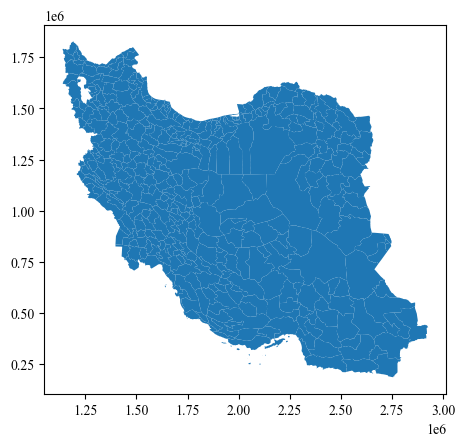

In [121]:
iran_county = gpd.read_file(r"C:\Users\Mahsa\Desktop\base\PHD3\bargh\PhD_3.gdb", layer="Shahrestan")
iran_county.plot()

In [122]:
iran_county.columns

Index(['OBJECTID', 'FARSI_NAM', 'Ostan', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')

In [123]:
geo = pd.read_pickle(r"C:\Users\Mahsa\Desktop\geo\processed\geo.pkl")
geo.dropna(subset=["county92"], inplace= True)

In [124]:
geo.columns

Index(['address', 'year', 'county89', 'county91', 'county92', 'county97',
       'county98', 'county99', 'county1400', 'county1401', 'county1402',
       'county1403'],
      dtype='object')

In [125]:
match_name = pd.read_csv(r"C:\Users\Mahsa\Desktop\base\energy poverty\Matched_Cell79_Cell80.csv")
match_name

,FARSI_NAM,county92,similarity_score
0,بناب,بناب,100.00
1,خرم دره,خرمدره,92.31
2,بندرانزل,بندرانزلي,94.12
3,كنگاور,کنگاور,83.33
4,سرپل ذهاب,سرپل ذهاب,100.00
...,...,...,...
424,بدره,بدره,100.00
425,داورزن,داورزن,100.00
426,رازوجرگل,راور,66.67
427,ابهر,ابهر,100.00


In [126]:
match_name["county92"].nunique()

419

In [105]:
in_names = match_name["county92"].unique()
geo.loc[~geo["county92"].isin(in_names),["address","county92"]]

,address,county92
240,1007,فريدونشهر
263,1102,چاه بهار
270,1109,كنارك
274,1113,زابلي
314,1407,كيار
397,2206,جاسك
407,2303,رئ
427,2407,كوثر
461,2806,مانه وسملقان
463,2808,راز و جرگلان


In [101]:
error_names = match_name.loc[match_name["county92"].duplicated()]["county92"]
match_name.loc[match_name["county92"].isin(error_names)]

,FARSI_NAM,county92,similarity_score
3,كنگاور,کنگاور,83.33
8,فريدون شه,فريدن,71.43
36,هريس,هريس,100.00
39,اسكو,اسکو,75.00
43,ميانه,ميانه,100.00
48,کوثر,کوار,75.00
93,بهار,بهار,100.00
107,مهران,مهران,100.00
190,راور,راور,100.00
199,چابهار,بهار,80.00


In [127]:
match_name.loc[48,"county92"]='كوثر'
match_name.loc[8,"county92"]='فريدونشهر'
match_name.loc[199,"county92"]='چاه بهار'
match_name.loc[238,"county92"]='مانه وسملقان'
match_name.loc[264,"county92"]='جاسك'
match_name.loc[279,"county92"]='رئ'
match_name.loc[330,"county92"]='كيار'
match_name.loc[353,"county92"]='كنارك'
match_name.loc[426,"county92"]='راز و جرگلان'
match_name.loc[350,"county92"]='زابلي'

In [128]:
match_name["county92"].nunique()

429

In [129]:
iran_county = pd.merge(iran_county, match_name, on = "FARSI_NAM", how = "left")
print(iran_county["county92"].isna().sum())
iran_county = pd.merge(iran_county, geo, on = "county92", how = "left")
print(iran_county["year"].isna().sum())
iran_county = pd.merge(iran_county, county_df2, left_on= "address", right_on = "county_code", how = "left")
print(iran_county.isna().sum())


0
0
OBJECTID             0
FARSI_NAM            0
Ostan                0
Shape_Length         0
Shape_Area           0
geometry             0
county92             0
similarity_score     0
address              0
year                 0
county89            33
county91             8
county97             0
county98             0
county99             0
county1400           0
county1401           0
county1402           0
county1403           0
county_code          1
2010                94
2011                94
2012                93
2013                32
2014                32
2015                32
2016                32
2017                32
2018                 1
2019                 1
2020                 2
2021                 1
2022                 1
2023                 1
2024                 1
dtype: int64


In [130]:
iran_county = iran_county[[
    'OBJECTID',        'FARSI_NAM',
    'Shape_Length',       'Shape_Area',         'geometry',
    'county92',    'year',      'county_code',               2010,
    2011,               2012,               2013,
    2014,               2015,               2016,
    2017,               2018,               2019,
    2020,               2021,               2022,
    2023,               2024
]]

In [131]:
province_gis = iran_provinces.drop(columns = "geometry")
province_gis = pd.DataFrame(province_gis)
county_gis = iran_county.drop(columns = "geometry")
county_gis = pd.DataFrame(county_gis)

In [135]:
county_gis.to_excel("county_gis.xlsx", index=False)
province_gis.to_excel("province_gis.xlsx", index=False)

# The data back from ArcGIS

In [33]:
county = gpd.read_file(r"C:\Users\Mahsa\Documents\ArcGIS\Projects\energy poverty\energy poverty.gdb", layer= "county")
county.columns

Index(['FARSI_NAM', 'county92', 'year', 'county_code', 'F2010', 'F2011',
       'F2012', 'F2013', 'F2014', 'F2015', 'F2016', 'F2017', 'F2018', 'F2019',
       'F2020', 'F2021', 'F2022', 'F2023', 'F2024', 'Shape_Length',
       'Shape_Area', 'geometry'],
      dtype='object')

In [34]:
county.drop(columns = ['year','Shape_Length','Shape_Area', 'geometry'], inplace= True)
county.rename(columns = {
    "F2010":2010,
    "F2011":2011,
    "F2012":2012,
    "F2013":2013,
    "F2014":2014,
    "F2015":2015,
    "F2016":2016,
    "F2017":2017,
    "F2018":2018,
    "F2019":2019,
    "F2020":2020,
    "F2021":2021,
    "F2022":2022,
    "F2023":2023,
    "F2024":2024
}, inplace = True)
county.head()

,FARSI_NAM,county92,county_code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,بناب,بناب,0312,16.15,41.06,23.11,8.85,19.28,26.23,23.78,13.53,24.39,18.73,10.28,10.26,16.01,3.69,10.20
1,خرم دره,خرمدره,1907,5.82,17.03,10.32,13.62,19.97,6.78,6.11,8.92,10.47,19.75,18.67,11.70,8.96,4.49,1.74
2,بندرانزل,بندرانزلي,0103,18.23,13.80,15.36,16.06,17.29,21.96,15.38,19.46,15.33,8.36,14.07,11.61,10.22,13.88,11.91
3,كنگاور,کنگاور,0507,11.60,8.57,20.82,14.95,15.48,20.60,16.80,14.57,13.81,14.57,3.73,14.32,9.07,9.64,3.30
4,سرپل ذهاب,سرپل ذهاب,0504,3.17,4.31,8.08,9.07,10.35,10.25,6.67,2.94,5.39,6.98,11.44,5.50,9.10,10.49,18.74


In [35]:
county = pd.melt(frame= county, id_vars=["FARSI_NAM","county92","county_code"], value_name= "energyPoorPer", var_name= "year")
county.head()

,FARSI_NAM,county92,county_code,year,energyPoorPer
0,بناب,بناب,0312,2010,16.15
1,خرم دره,خرمدره,1907,2010,5.82
2,بندرانزل,بندرانزلي,0103,2010,18.23
3,كنگاور,کنگاور,0507,2010,11.60
4,سرپل ذهاب,سرپل ذهاب,0504,2010,3.17


In [140]:
province = gpd.read_file(r"C:\Users\Mahsa\Documents\ArcGIS\Projects\energy poverty\energy poverty.gdb", layer= "province")
province.columns

Index(['Province_N', 'Province_E', 'province', 'province_code', 'F2010',
       'F2011', 'F2012', 'F2013', 'F2014', 'F2015', 'F2016', 'F2017', 'F2018',
       'F2019', 'F2020', 'F2021', 'F2022', 'F2023', 'F2024', 'Shape_Length',
       'Shape_Area', 'geometry'],
      dtype='object')

In [141]:
province.drop(columns = ['Shape_Length', 'Shape_Area', 'geometry'], inplace= True)
province.rename(columns = {
    "F2010":2010,
    "F2011":2011,
    "F2012":2012,
    "F2013":2013,
    "F2014":2014,
    "F2015":2015,
    "F2016":2016,
    "F2017":2017,
    "F2018":2018,
    "F2019":2019,
    "F2020":2020,
    "F2021":2021,
    "F2022":2022,
    "F2023":2023,
    "F2024":2024
}, inplace = True)
province.head()

,Province_N,Province_E,province,province_code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,قزوین,Qazvin,Qazvin,26,8.74,13.66,8.05,8.99,8.31,7.88,6.77,5.79,4.23,4.26,2.08,2.07,1.64,1.11,0.18
1,اردبیل,Ardebil,Ardabil,24,4.08,7.38,7.21,6.54,5.98,7.47,8.40,6.29,7.57,10.11,7.89,9.75,8.28,6.76,5.36
2,زنجان,Zanjan,Zanjan,19,14.20,19.29,12.90,13.26,17.61,14.10,12.18,14.18,11.23,12.03,12.85,8.36,5.92,3.84,3.55
3,سمنان,Semnan,Semnan,20,29.78,29.38,30.38,13.75,12.94,11.83,11.92,11.31,12.92,11.24,13.96,6.74,5.53,6.06,3.71
4,قم,Qom,Qom,25,16.22,9.67,6.92,10.91,7.11,7.33,1.82,2.11,1.74,3.12,3.50,2.61,5.69,3.15,2.62


In [142]:
province = pd.melt(frame = province, id_vars=['Province_N', 'Province_E', 'province', 'province_code'], var_name="year", value_name="energyPoorPer")
province.head()

,Province_N,Province_E,province,province_code,year,energyPoorPer
0,قزوین,Qazvin,Qazvin,26,2010,8.74
1,اردبیل,Ardebil,Ardabil,24,2010,4.08
2,زنجان,Zanjan,Zanjan,19,2010,14.20
3,سمنان,Semnan,Semnan,20,2010,29.78
4,قم,Qom,Qom,25,2010,16.22


In [36]:
# --- Define Gini function ---
def gini(array):
    """Compute Gini coefficient of a numpy array."""
    array = np.array(array)
    array = array[~np.isnan(array)]  # remove NaN
    if len(array) == 0:
        return np.nan
    array = np.sort(array)
    n = len(array)
    cumvals = np.cumsum(array)
    return (2 * np.sum((np.arange(1, n + 1) * array)) / (n * np.sum(array))) - (n + 1) / n

# --- Calculate Gini by year ---
gini_results = (
    county.groupby("year")["energyPoorPer"]
    .apply(lambda x: gini(x))
    .reset_index(name="Gini_Coefficient")
)

print(gini_results)


    year  Gini_Coefficient
0   2010              0.35
1   2011              0.41
2   2012              0.40
3   2013              0.37
4   2014              0.40
5   2015              0.39
6   2016              0.42
7   2017              0.44
8   2018              0.43
9   2019              0.45
10  2020              0.44
11  2021              0.49
12  2022              0.48
13  2023              0.54
14  2024              0.53


In [144]:
# --- Calculate Gini by year ---
gini_results = (
    province.groupby("year")["energyPoorPer"]
    .apply(lambda x: gini(x))
    .reset_index(name="Gini_Coefficient")
)

print(gini_results)

    year  Gini_Coefficient
0   2010              0.21
1   2011              0.28
2   2012              0.28
3   2013              0.26
4   2014              0.27
5   2015              0.29
6   2016              0.33
7   2017              0.33
8   2018              0.32
9   2019              0.25
10  2020              0.30
11  2021              0.35
12  2022              0.32
13  2023              0.38
14  2024              0.39


In [145]:
for year in range(2018, 2025):
    df = county.loc[(county["year"]==year)& (county["energyPoorPer"].isna())]
    print(df)

    county92 county_code  year  energyPoorPer
410  آغاجاري              2018            NaN
    county92 county_code  year  energyPoorPer
839  آغاجاري              2019            NaN
     county92 county_code  year  energyPoorPer
1021  ابوموسي        2201  2020            NaN
1268  آغاجاري              2020            NaN
     county92 county_code  year  energyPoorPer
1697  آغاجاري              2021            NaN
     county92 county_code  year  energyPoorPer
2126  آغاجاري              2022            NaN
     county92 county_code  year  energyPoorPer
2555  آغاجاري              2023            NaN
     county92 county_code  year  energyPoorPer
2984  آغاجاري              2024            NaN


In [ ]:
county.to_excel("county_melt.xlsx")
province.to_excel("province_melt.xlsx")

# Visualization of word table

In [4]:
from docx import Document
doc = Document(r"C:\Users\Mahsa\Desktop\energy poverty 04.11.2025.docx")

In [ ]:
'''
Document
 └── tables (list)
       ├── Table 0
       │     ├── rows (list)
       │     │     ├── Row 0
       │     │     │     ├── cells (list)
       │     │     │     │     ├── Cell 0 → text: "Header 1"
       │     │     │     │     └── Cell 1 → text: "Header 2"
       │     │     ├── Row 1
       │     │     │     ├── Cell 0 → text: "Value 1"
       │     │     │     └── Cell 1 → text: "Value 2"


'''


In [30]:
# Access the first table
table = doc.tables[1]

# Extract all rows and cells
data = []
for row in table.rows:
    row_data = [cell.text.strip() for cell in row.cells]
    data.append(row_data)

# Convert to DataFrame
df = pd.DataFrame(data)

# Optionally, use the first row as the header
df.columns = df.iloc[0]  # Set header
df = df[1:]
df.columns = df.columns.str.strip()
df["Year"] = df["Year"].astype("int") 
df["Moran’s I index"] = df["Moran’s I index"].astype("float64") 
df["Gini index"] = df["Gini index"].astype("float64") 
df.columns = df.columns.str.replace("’", "'", regex=False)
df

,Year,Moran's I index,Z_score,P_value,Gini index
1,2010,0.26,6.697242,0.000000,0.35
2,2011,0.33,8.553563,0.000000,0.41
3,2012,0.26,6.703694,0.000000,0.40
4,2013,0.33,10.090406,0.000000,0.37
5,2014,0.32,9.66685,0.000000,0.40
6,2015,0.24,7.34142,0.000000,0.39
7,2016,0.33,10.117062,0.000000,0.42
8,2017,0.31,9.352276,0.000000,0.44
9,2018,0.34,11.187461,0.000000,0.43
10,2019,0.28,9.375059,0.000000,0.45


In [37]:
df.to_pickle("docx_table.pkl")

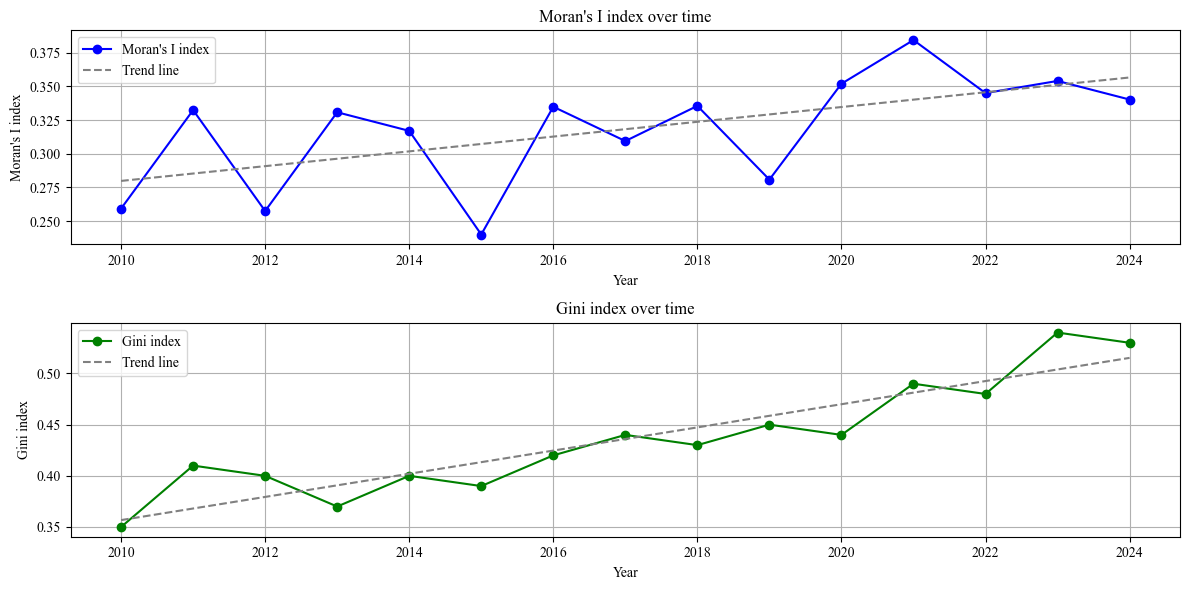

In [36]:
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# ---------- 1️⃣ Moran's I index ----------
x = df["Year"]
y1 = df["Moran's I index"]

# Plot data points
ax[0].plot(x, y1, marker='o', color='blue', label="Moran's I index")

# Calculate and plot trend line
z1 = np.polyfit(x, y1, 1)  # 1 = linear fit
p1 = np.poly1d(z1)
ax[0].plot(x, p1(x), "--", color="grey", label="Trend line")

# Labels and grid
ax[0].set_title("Moran's I index over time")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Moran's I index")
ax[0].legend()
ax[0].grid(True)


# ---------- 2️⃣ Gini index ----------
y2 = df["Gini index"]

# Plot data points
ax[1].plot(x, y2, marker='o', color='green', label="Gini index")

# Calculate and plot trend line
z2 = np.polyfit(x, y2, 1)
p2 = np.poly1d(z2)
ax[1].plot(x, p2(x), "--", color="grey", label="Trend line")

# Labels and grid
ax[1].set_title("Gini index over time")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Gini index")
ax[1].legend()
ax[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()